In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from biosppy.signals import ecg
import os
import neurokit as nk

In [2]:
ecg_data_file = 'D:\data\ibeat\eplab\Subject44_data.hdf'
ecg_data = pd.read_hdf(ecg_data_file, 'eplab')

## cut ecg data

In [3]:
ecg_data = ecg_data[(ecg_data['utc_adjusted']> 1527108380) & (ecg_data['utc_adjusted']<1527108473)]

## Run Biosppy ECG Analysis on chunks:

In [4]:

ecg_chunks = []
print('Analyzing {} chunks'.format(len(ecg_data.section.unique())))
for section in ecg_data.section.unique():
    ecg_section = ecg_data[ecg_data.section == section]

    # Run biosppy ecg analysis
    ecg_analysis = ecg.ecg(signal=ecg_section.II, sampling_rate=976.942, show=False)
    
    ecg_chunks.append(pd.DataFrame(dict(ecg_heart_rate=ecg_analysis['heart_rate'], 
                                        utc=ecg_analysis['heart_rate_ts'] + ecg_section.utc_adjusted.iloc[0])))

# Concatinate results
ecg_analysis = pd.concat(ecg_chunks)

Analyzing 1 chunks


C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index

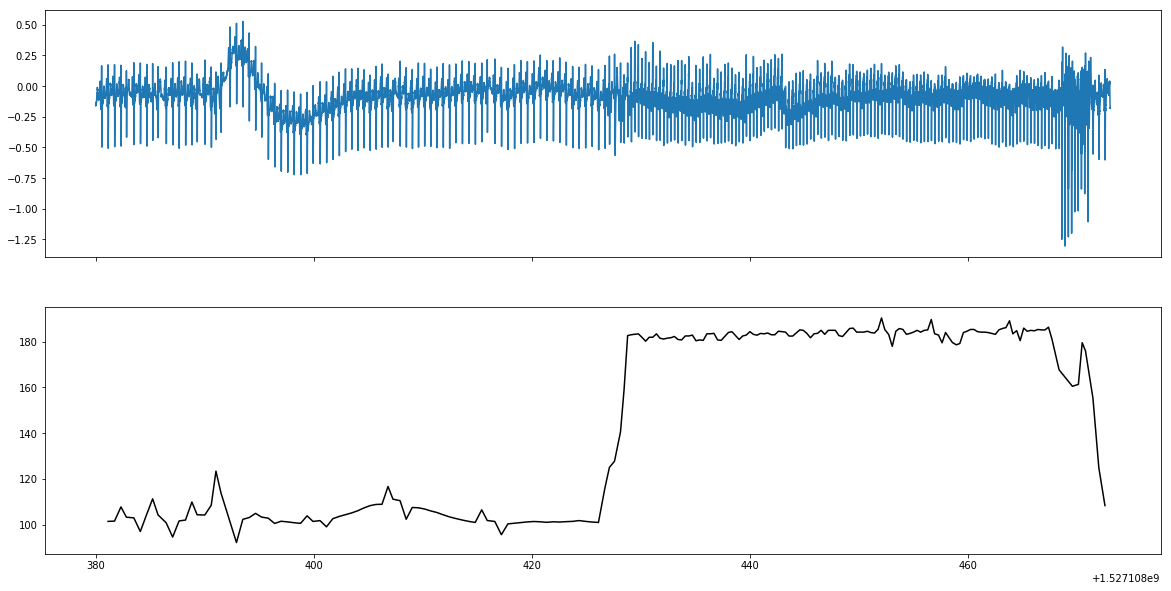

In [5]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

# Raw ECG Signal
ax[0].plot(ecg_data.utc_adjusted, ecg_data.II)

ax[1].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate')
# ax[-1].set_xlim([ecg_data.utc_adjusted.min(), ecg_data.utc_adjusted.max()])

## Baseline correction and complete the R peaks

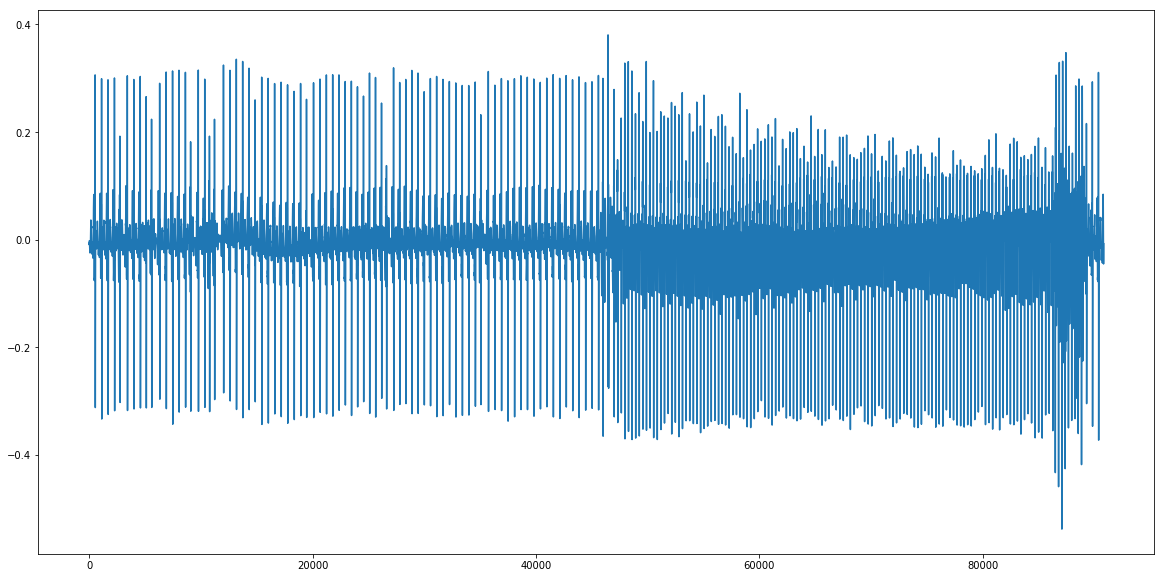

In [6]:
SR = 976.942
ecg_sig = ecg_data.II
out = ecg.ecg(signal=ecg_sig, sampling_rate=SR,show = False)


plt.figure(figsize=(20,10))
plt.plot(out['filtered'])

## Two ways to find the indexes of R peaks: neurokit.py & biosppy.py

In [7]:
processed_ecg = nk.ecg_process(ecg_sig, rsp=None, sampling_rate=976.942)
rpeaks = processed_ecg['ECG']['R_Peaks']
rpeaks2 = out['rpeaks']
HR = processed_ecg['df']['Heart_Rate'].tolist()

NeuroKit Warning: ecg_hrv(): Sequence too short to compute interpolation. Will skip many features.


C:\Users\imapi\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.18.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\imapi\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.18.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\imapi\AppData\Roaming\Python\Python37\site-packages\neurokit\bio\bio_ecg.py:366: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  quality["Cardiac_Cycles_Signal_Quality"] = predict[lead].as_matrix()


## If the RR falls below 600 ms(from above 600ms), tachycardia has initiated. 

In [8]:
# rpeaks_tachy gives the indexes where tachycardia initiates.
# Use rpeaks2, which is calculated by biopssy.py
rpeaks_tachy = []
SR = 976.942
for i in range(len(rpeaks2)-2):
    if rpeaks2[i+1]-rpeaks2[i] > 0.6*SR and rpeaks2[i+2]-rpeaks2[i+1] < 0.6*SR:
        rpeaks_tachy.append(rpeaks2[i+1])

        
# Add 1.5 sec ECG data points before and after Rpeaks where tachycardia occurs.
begin = []
end = []
time_add = 1.5
data_add = round(time_add*SR)
for i in range(len(rpeaks_tachy)):
    begin.append(rpeaks_tachy[i]-data_add)
    end.append(rpeaks_tachy[i]+data_add)



## Extract and plot the tachycardia sections.

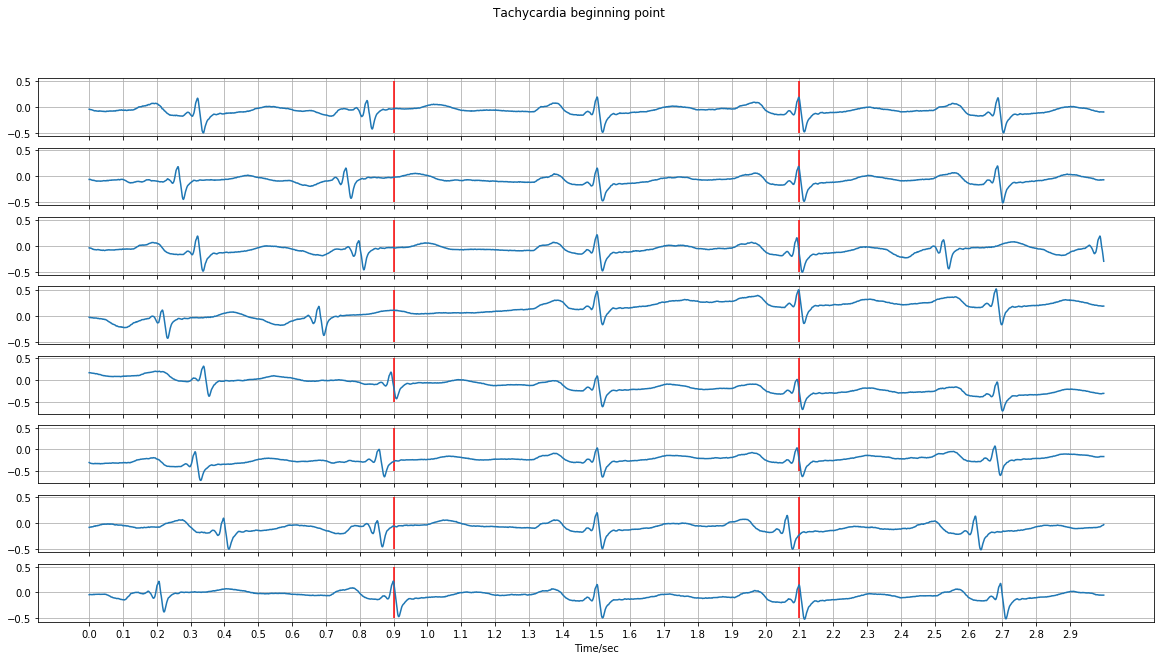

In [15]:
t  = np.linspace(0, 2*time_add, num=2*data_add)
fig, ax = plt.subplots(len(rpeaks_tachy), 1, sharex=True, figsize=(20, 10))
plt.suptitle('Tachycardia beginning point')

for i in range(len(begin)):
    # Use locals() function to set variable names as tachy1, tachy2, ...
    name = 'tachy'+str(i)
    locals()['tachy'+str(i)]= ecg_sig[begin[i]:end[i]]
    ax[i].vlines(0.9, -0.5, 0.5, colors = "r")
    ax[i].vlines(2.1, -0.5, 0.5, colors = "r")
    ax[i].plot(t,locals()['tachy'+str(i)])
    plt.xlabel('Time/sec')
    plt.xticks(np.arange(0,3,0.1))
    plt.rcParams['axes.grid'] = True

# x-axis to show real date time for each strip.

## Bradycardia(RR > 1000ms)

In [ ]:
rpeaks_brady = []
SR = 976.942
for i in range(len(rpeaks)-2):
    if rpeaks[i+1]-rpeaks[i] <1*SR and rpeaks[i+2]-rpeaks[i+1] >1*SR:
        rpeaks_brady.append(rpeaks[i+1])

print(rpeaks_brady)

begin_brady = []
end_brady = []
data_add = round(1.5*SR)
for i in range(len(rpeaks_brady)):
    begin_brady.append(rpeaks_brady[i]-data_add)
    end_brady.append(rpeaks_brady[i]+data_add)
    
t  = np.linspace(0, 3, num=2*data_add)
fig, ax = plt.subplots(len(rpeaks_brady), 1, sharex=True, figsize=(20, 10))
for i in range(len(begin)):
# Use locals() function to set variable names as brady1, brady2, ...
    name = 'brady'+str(i)
    locals()['brady'+str(i)]= ecg_sig[begin_brady[i]:end_brady[i]]
    ax[i].plot(t,locals()['brady'+str(i)])
    plt.xlabel('Time')

## Calculate and visualize RR intervals

In [11]:
rrinterval = []
for i in range(len(rpeaks2)-1):
    rrinterval.append((rpeaks2[i+1]-rpeaks2[i])/976.942)
del(rrinterval[0])
rrinterval[0:5]

[0.5895948787133729,
 0.5906184809333614,
 0.500541485574374,
 0.6796718740723605,
 0.5957364920333039]

In [12]:
hr = []
for i in range(len(rrinterval)):
    hr.append(60/rrinterval[i])
hr[0:5]

[101.76479166666668,
 101.58842287694974,
 119.87018404907975,
 88.27789156626505,
 100.71567010309279]

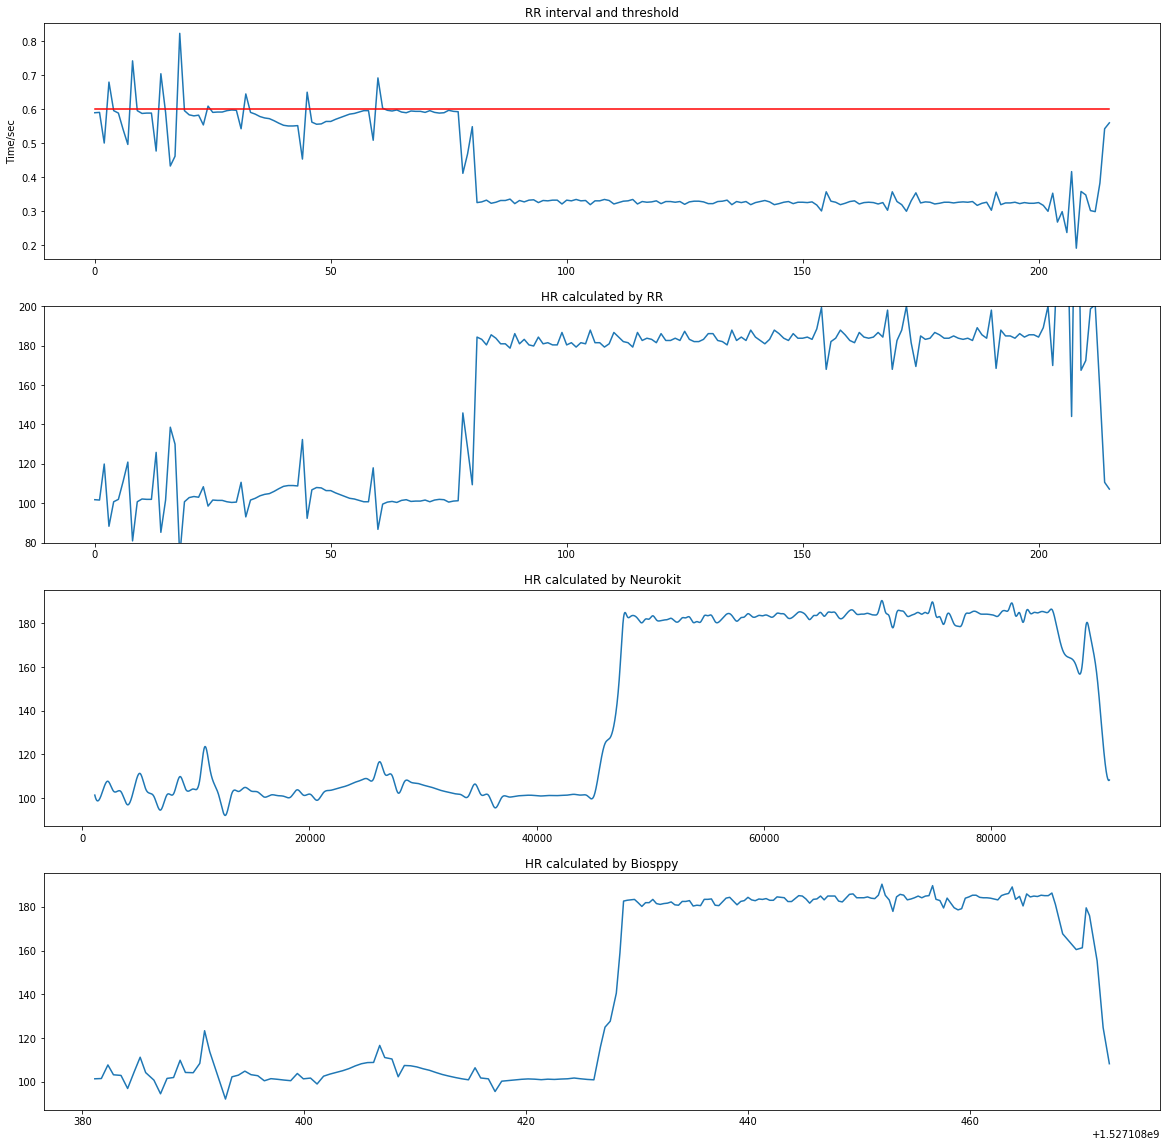

In [17]:
fig, ax = plt.subplots(4, 1, sharex=False, figsize=(20, 20))
threshold = [0.6] * len(rrinterval)
# Raw ECG Signal
ax[0].plot(rrinterval)
ax[0].plot(threshold, c='r')
ax[0].set_title('RR interval and threshold')
ax[0].set_ylabel('Time/sec')
ax[1].plot(hr)
ax[1].set_ylim([80,200])
ax[1].set_title('HR calculated by RR')
ax[2].plot(HR)
ax[2].set_title('HR calculated by Neurokit')
ax[3].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate)
ax[3].set_title('HR calculated by Biosppy')
plt.rcParams['axes.grid'] = False